In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import os

from dataset import Spectra, transform0, FT_spectra
import matplotlib.pyplot as plt

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"
]

In [2]:
# --- Load datasets ---
data_path = os.path.join('datasets')
train_dataset = Spectra(data_path, transform=transform0) 
test_dataset = Spectra(data_path, transform=transform0)

In [3]:
# --- Load models ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dae = torch.load('pretrained/dae_model_9.pth', map_location=device)
vae = torch.load('pretrained/vae_model_9.pth', map_location=device)
dae.to(device)
vae.to(device)

# --- Fit PCA on training set ---
pca = PCA(n_components=9)
pca.fit(train_dataset.Spectra)

PCA(n_components=9)

In [4]:
def run_latent_models(train_dataset, test_dataset, dae_model, vae_model, pca_model, batch_size=256, device='cpu'):
    dae_model.eval()
    vae_model.eval()

    # Collect everything batch-wise
    input_arr = []
    max_arr = []
    slme_arr = []
    material_names_arr = []
    dae_latents, dae_recons = [], []
    vae_latents, vae_recons = [], []
    pca_latents, pca_recons = [], []
    vae_reparam_latents, vae_reparam_recons = [], []

    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    for batch in loader:
        x = batch['x1'].to(device)                  # spectra (B, 1, L)
        maxs = batch['max'].cpu().numpy()           # shape (B,)
        slme = batch['slme'].cpu().numpy()          # shape (B,)
        material_names = batch['mns']               # shape (B,)

        # Save original spectra and slme
        input_batch = x.cpu().numpy()[:, 0, :]      # (B, L)
        input_arr.append(input_batch)
        slme_arr.append(slme)
        max_arr.append(maxs)
        material_names_arr.extend(material_names)

        # DAE forward
        with torch.no_grad():
            dae_latent = dae_model.latent(x)
            dae_recon = dae_model.reconstr(x)
            dae_latent = dae_latent.cpu().numpy()           # (B, latent_dim)
            dae_recon = dae_recon.cpu().numpy()[:, 0, :]   # (B, L)
        dae_latents.append(dae_latent)
        dae_recons.append(dae_recon)


        x = batch['x1'].to(device)   
        # VAE forward
        with torch.no_grad():
            vae_pred = vae_model(x)
            vae_reparam_latent = vae_pred[2]
            vae_reparam_recon = vae_pred[0]
            vae_reparam_latent = vae_reparam_latent.cpu().numpy()
            vae_reparam_recon = vae_reparam_recon.cpu().numpy()[:, 0, :]          
            
            vae_latent = vae_model.latent(x)
            vae_recon = vae_model.reconstr(x)
            vae_latent = vae_latent.cpu().numpy()
            vae_recon = vae_recon.cpu().numpy()[:, 0, :] 

        vae_reparam_latents.append(vae_reparam_latent)
        vae_reparam_recons.append(vae_reparam_recon)
        
        vae_latents.append(vae_latent)
        vae_recons.append(vae_recon)

        # PCA on the same batch (flatten to 2D: (B, L))
        pca_latent = pca_model.transform(input_batch)
        pca_recon = pca_model.inverse_transform(pca_latent)
        pca_latents.append(pca_latent)
        pca_recons.append(pca_recon)

    # Concatenate all batches
    result = {
        'input': np.concatenate(input_arr, axis=0),
        'max':np.concatenate(max_arr, axis =0),
        'slme': np.concatenate(slme_arr, axis=0),
        'material_name': np.array(material_names_arr),  # shape (N,)
        'dae': {'latent': np.concatenate(dae_latents, axis=0), 'recon': np.concatenate(dae_recons, axis=0)},
        'vae': {'latent': np.concatenate(vae_latents, axis=0), 'recon': np.concatenate(vae_recons, axis=0)},
        'vae_reparam': {'latent': np.concatenate(vae_reparam_latents, axis=0), 'recon': np.concatenate(vae_reparam_recons, axis=0)},
        'pca': {'latent': np.concatenate(pca_latents, axis=0), 'recon': np.concatenate(pca_recons, axis=0)},
    }
    return result


In [5]:
# --- Run inference ---
results = run_latent_models(train_dataset, test_dataset, dae, vae, pca, batch_size=64, device=device)

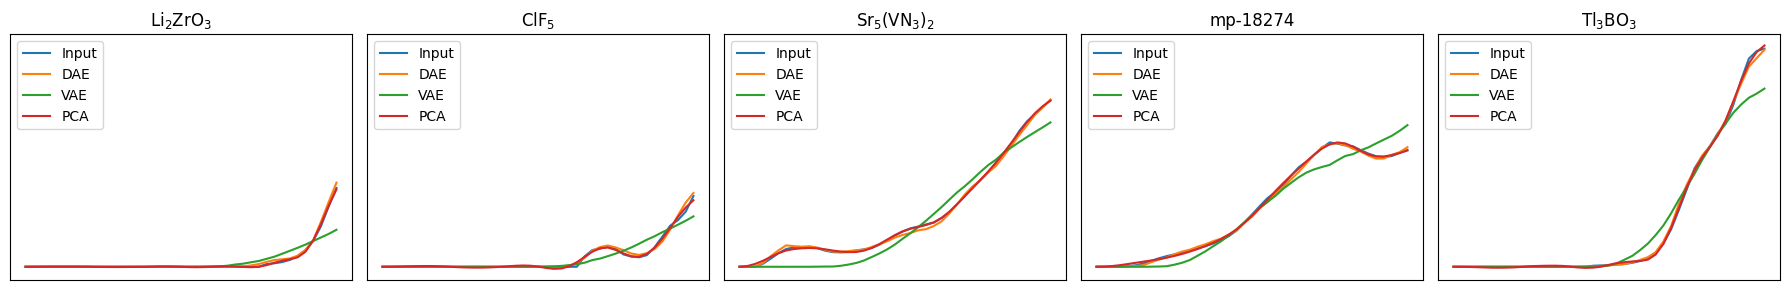

In [6]:
material_names = np.array(results['material_name'])  # shape (N,)
target_names = ['mp-4156', 'mp-1213763', 'mp-1247227', 'mp-18274', 'mp-4584']
mpid_to_name = {
    'mp-4156': r'Li$_2$ZrO$_3$',       
    'mp-1213763': r'ClF$_5$',      
    'mp-1247227': r'Sr$_5$(VN$_3$)$_2$',      
    'mp-2201': r'PbSe',      
    'mp-4584': r'Tl$_3$BO$_3$'        
}


# Find indices for each target material
indices = [np.where(material_names == name)[0][0] for name in target_names]

fig, axs = plt.subplots(1, 5, figsize=(18, 3), sharey=True)

for ax, idx, mpid in zip(axs, indices, target_names):
    ax.plot(results['input'][idx], label='Input', c=colors[0])
    ax.plot(results['dae']['recon'][idx], label='DAE', c=colors[1])
    ax.plot(results['vae']['recon'][idx], label='VAE', c=colors[2])
    ax.plot(results['pca']['recon'][idx], label='PCA', c=colors[3])
    # Use real/material name as the title
    ax.set_title(mpid_to_name.get(mpid, mpid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
def pearson_correlation_matrix(X, Y):
    """Returns Pearson correlation coefficient matrix between X and Y."""
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    cov = Xc.T @ Yc / (X.shape[0] - 1)
    Xstd = Xc.std(axis=0, ddof=1)
    Ystd = Yc.std(axis=0, ddof=1)
    return cov / np.outer(Xstd, Ystd)

def plot_covariance_matrix(features, latents, feature_labels=None, lat_labels=None, title=None, savepath=None):
    """Visualises the covariance/correlation between features and latent dimensions."""
    covmat = pearson_correlation_matrix(features, latents)
    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.imshow(covmat, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)
    # Overlay correlation values
    for i in range(covmat.shape[0]):
        for j in range(covmat.shape[1]):
            ax.text(j, i, f'{covmat[i, j]:.2f}', ha='center', va='center', color='black')
    # Labels
    if feature_labels is not None:
        ax.set_yticks(range(len(feature_labels)))
        ax.set_yticklabels(feature_labels)
    else:
        ax.set_yticks([])
    if lat_labels is not None:
        ax.set_xticks(range(len(lat_labels)))
        ax.set_xticklabels(lat_labels, rotation=45)
    else:
        ax.set_xticks([])
    if title:
        ax.set_title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

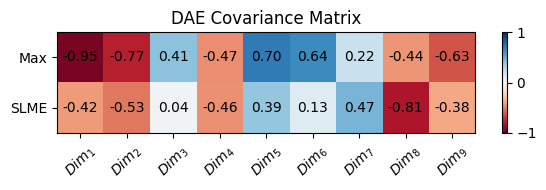

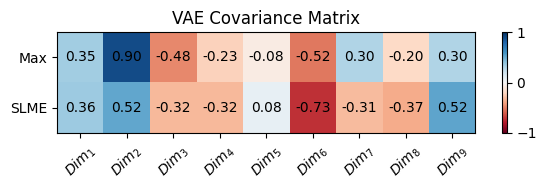

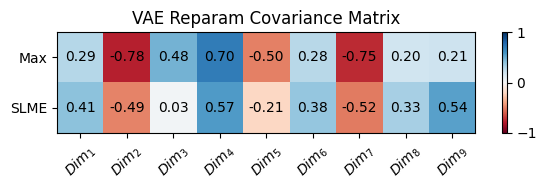

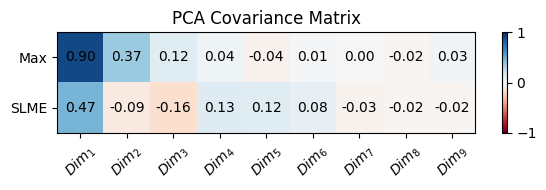

In [8]:
valid_idx = np.where(results['slme']>=0)[0]

features = np.concatenate((results['max'][valid_idx].reshape(-1, 1), results['slme'][valid_idx].reshape(-1, 1)), axis=1)

plot_covariance_matrix(
    features,  results['dae']['latent'][valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(results['dae']['latent'].shape[1])],
    title='DAE Covariance Matrix'
)

plot_covariance_matrix(
    features,  results['vae']['latent'][valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(results['vae']['latent'].shape[1])],
    title='VAE Covariance Matrix'
)

plot_covariance_matrix(
    features,  results['vae_reparam']['latent'][valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(results['vae']['latent'].shape[1])],
    title='VAE Reparam Covariance Matrix'
)

plot_covariance_matrix(
    features,  results['pca']['latent'][valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(results['pca']['latent'].shape[1])],
    title='PCA Covariance Matrix'
)

In [9]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def plot_lasso_coefficients(coefs, title="Lasso Coefficient"):
    plt.figure(figsize=(5, 2.9))
    x_labels = [r'$Dim_{{{}}}$'.format(i+1) for i in range(len(coefs))]
    plt.bar(np.arange(len(coefs)), np.abs(coefs), width=0.6)
    plt.title(title)
    plt.xticks(np.arange(len(coefs)), x_labels, rotation=0)
    ymin, ymax = plt.ylim()
    #plt.yticks([ymin, ymax], [])
    plt.tight_layout()
    plt.show()

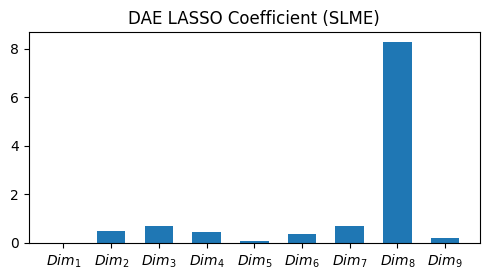

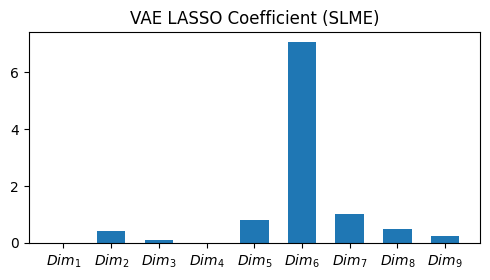

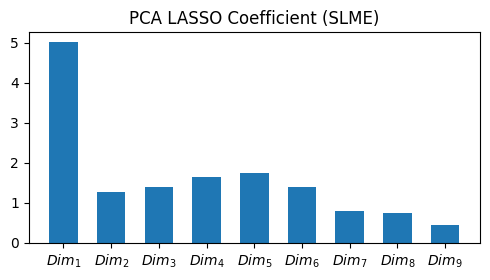

In [10]:
def run_lasso_latent(latents, target, label_prefix="Dim", model_name="Model", alpha=0.1):
    target = target.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(latents, target, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    #coef_abs = np.abs(lasso.coef_)
    #coef_abs_rel = coef_abs/coef_abs.sum()
    plot_lasso_coefficients(lasso.coef_, title=f"{model_name} LASSO Coefficient (SLME)")
    return lasso


dae_lasso = run_lasso_latent(results['dae']['latent'][valid_idx], results['slme'][valid_idx], label_prefix="DAE", model_name="DAE")
vae_lasso = run_lasso_latent(results['vae']['latent'][valid_idx], results['slme'][valid_idx], label_prefix="VAE", model_name="VAE")
pca_lasso = run_lasso_latent(results['pca']['latent'][valid_idx], results['slme'][valid_idx], label_prefix="PCA", model_name="PCA")

In [11]:
from sklearn.metrics import pairwise_distances

def get_top_n_materials(material_names, slme_values, n):
    """Return top-n material names and their indices by SLME (descending)."""
    idx = np.argsort(slme_values)[-1*n:][::-1]
    return material_names[idx], idx


def get_sorted_by_distance(latents, material_names, ref_idx, metric):
    """Return material names sorted by distance to reference vector."""
    ref_vec = latents[ref_idx].reshape(1, -1)
    dists = pairwise_distances(latents, ref_vec, metric=metric).flatten()
    return material_names[np.argsort(dists)]


def nearest_neighbor_search_(positions, sorted_eff_indices):
    found_top_n = []
    count_top_n = 0

    for ii in range(len(positions)):
        if positions[ii] in sorted_eff_indices:
            count_top_n += 1
        found_top_n.append(count_top_n / len(sorted_eff_indices))  # Percentage of top n found

    return found_top_n


def discovery_fraction(sorted_names, top_n_names):
    """Cumulative fraction of top-n found as you traverse sorted_names."""
    found = 0
    frac = []
    for idx in range(len(sorted_names)):
        name = sorted_names[idx]
        if name in top_n_names:
            found += 1
        frac.append(found / len(top_n_names))
    return np.array(frac)


def compute_discovery_from_latents(lvs_array, mat_vecs, top_n_mat, ref_idx, metric='cosine'): 
    norm_lvs_array = StandardScaler().fit_transform(lvs_array)#[:, 7:8] #best dims 
    positions = get_sorted_by_distance(norm_lvs_array, mat_vecs, ref_idx, metric)    
    result = discovery_fraction(positions, top_n_mat)
    return result


def rnd_search(material_name, material_idxs):
    random_trials = 20
    random_results = np.zeros((random_trials, len(material_name)))
    for i in range(random_trials):
        sampled_indices = np.random.choice(len(material_name), len(material_name), replace=False)
        count_top_n = np.isin(sampled_indices, material_idxs).cumsum() / top_n
        random_results[i, :] = count_top_n
    
    random_mean = random_results.mean(axis=0)
    random_std = random_results.std(axis=0)
    return random_mean, random_std


In [12]:
ref_idx = np.where(results['material_name'] =='mp-2534')[0]  #GaAs
ref_idx = [np.argmax(results['slme'].reshape(-1))] #Top SLME

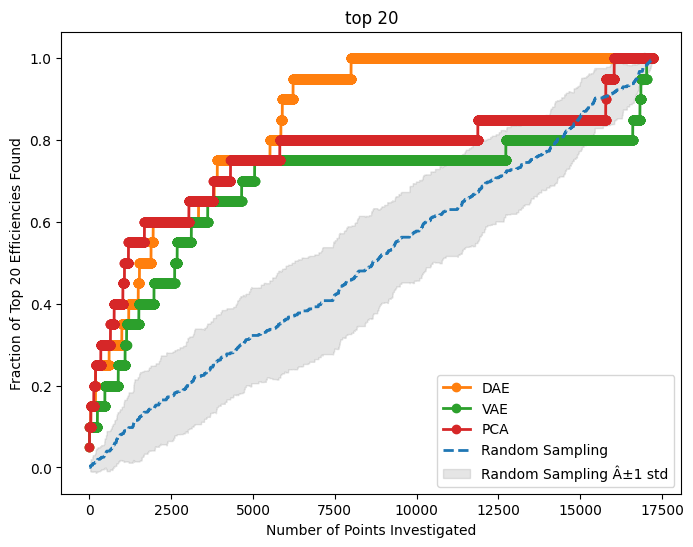

In [13]:
top_n = 20

material_ids, material_idxs = get_top_n_materials(results['material_name'], results['slme'].reshape(-1), top_n)


#manhattan
dae_results = compute_discovery_from_latents(results['dae']['latent'], results['material_name'], material_ids, ref_idx, metric = 'manhattan')
vae_results = compute_discovery_from_latents(results['vae']['latent'], results['material_name'], material_ids, ref_idx, metric = 'manhattan')
pca_results = compute_discovery_from_latents(results['pca']['latent'], results['material_name'], material_ids, ref_idx, metric = 'manhattan')

random_mean, random_std = rnd_search(results['material_name'], material_idxs)

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(1, len(dae_results) + 1), dae_results, label="DAE", marker='o', color=colors[1], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), vae_results, label="VAE", marker='o', color=colors[2], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), pca_results, label="PCA", marker='o', color=colors[3], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), random_mean, label="Random Sampling", linestyle='dashed', color=colors[0], lw=2)
ax.fill_between(range(1, len(dae_results) + 1), random_mean - random_std, random_mean + random_std, color='gray', alpha=0.2, label="Random Sampling Â±1 std")
plt.xlabel("Number of Points Investigated")
plt.ylabel(f"Fraction of Top {top_n} Efficiencies Found")
plt.legend()
plt.title(f"top {top_n}")
plt.show()

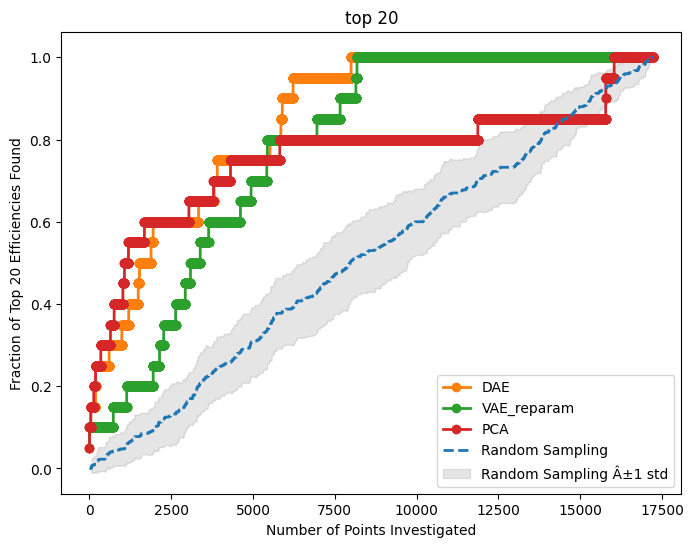

In [14]:
top_n = 20

material_ids, material_idxs = get_top_n_materials(results['material_name'], results['slme'].reshape(-1), top_n)


#manhattan
dae_results = compute_discovery_from_latents(results['dae']['latent'], results['material_name'], material_ids, ref_idx, metric = 'manhattan')
vae_reparam_results = compute_discovery_from_latents(results['vae_reparam']['latent'], results['material_name'], material_ids, ref_idx, metric = 'manhattan')
pca_results = compute_discovery_from_latents(results['pca']['latent'], results['material_name'], material_ids, ref_idx, metric = 'manhattan')

random_mean, random_std = rnd_search(results['material_name'], material_idxs)


colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(1, len(dae_results) + 1), dae_results, label="DAE", marker='o', color=colors[1], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), vae_reparam_results, label="VAE_reparam", marker='o', color=colors[2], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), pca_results, label="PCA", marker='o', color=colors[3], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), random_mean, label="Random Sampling", linestyle='dashed', color=colors[0], lw=2)
ax.fill_between(range(1, len(dae_results) + 1), random_mean - random_std, random_mean + random_std, color='gray', alpha=0.2, label="Random Sampling Â±1 std")
plt.xlabel("Number of Points Investigated")
plt.ylabel(f"Fraction of Top {top_n} Efficiencies Found")
plt.legend()
plt.title(f"top {top_n}")
plt.show()